## 1 - Carrega informações do dataframe  
## 2 - Criação do encoder e da matriz binária para cada coluna que iremos usar para classificação  
## 3 - gera o corpus (bag of words) e vetoriza  
## 4 - Faz a transformação TFIDF  
## 5 - Cria bases de treinamento e validação  
## 6 - Cria modelo  
## 7 - Analisa a acurária e a perda de cada modelo  
## 8 - Cria predições para cada modelo treinado  
## 9 - Aplica o modelo na base completa e analisa resultados  

In [1]:
import pandas as pd
import numpy as np
import random
import os 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from collections import namedtuple
from typing import Dict


## 1 - Carrega informações do dataframe

### 1.1 - dados de descrição limpa (com stopwords e com afixos)

In [2]:
df_itens = pd.read_parquet('itens_desc_limpa_sem_stopwords_stemming.parquet')
df_tec = pd.read_parquet('2_tec_desc_limpa.parquet')

In [3]:
len(df_itens), len(df_tec)

(26115, 10147)

In [4]:
df_itens[df_itens['capitulo'] == '00']

,descricao_limpa_sem_stopwords_stemming,capitulo,posicao,subposicao,item,subitem


In [5]:
# Duplicar linhas com somente 1 ou 2 exemplos
df_itens = df_itens.append(df_itens[df_itens['capitulo'].map(df_itens['capitulo'].value_counts()) <= 2])

In [6]:
df_itens = df_itens.rename(columns={'descricao_limpa_sem_stopwords_stemming': 'descricao_limpa'})

In [7]:
df_itens.head()

,descricao_limpa,capitulo,posicao,subposicao,item,subitem
0,masc fac hidrat embal 25ml day dre miracl vali...,33,04,99,1,0
1,dioctil ftalat flex bag d 20 tonel metr diocty...,29,17,32,0,0
2,sol calc borrach belfast mx,64,06,20,0,0
3,sol calc borrach lyon mx,64,06,20,0,0
4,sol calc borrach lyon mx,64,06,20,0,0


In [8]:
df_itens[df_itens['capitulo'] == '99']

,descricao_limpa,capitulo,posicao,subposicao,item,subitem
4441889,,99,99,99,9,9
4337496,seam dron import,99,99,99,9,9
4441889,,99,99,99,9,9
4337496,seam dron import,99,99,99,9,9


In [9]:
len(df_itens)

26117

In [10]:
# apaga linhas vazias
df_itens = df_itens.drop(df_itens[df_itens['descricao_limpa'] == ''].index)

In [11]:
len(df_itens)

26104

In [12]:
df_tec.head()

,descricao,ncm,ncm_str,capitulo,posicao,subposicao,item,subitem,descricao_limpa
0,Reprodutores de raca pura Cavalos Cavalos as...,1012100.0,01012100,01,01,21,0,0,reprodutores de raca pura cavalos cavalos asin...
1,Outros Cavalos Cavalos asininos e muares vi...,1012900.0,01012900,01,01,29,0,0,outros cavalos cavalos asininos e muares vivos
2,Asininos Cavalos asininos e muares vivos,1013000.0,01013000,01,01,30,0,0,asininos cavalos asininos e muares vivos
3,Outros Cavalos asininos e muares vivos,1019000.0,01019000,01,01,90,0,0,outros cavalos asininos e muares vivos
4,Prenhes ou com cria ao pe Reprodutores de raca...,1022110.0,01022110,01,02,21,1,0,prenhes ou com cria ao pe reprodutores de raca...


In [13]:
df_tec = df_tec[['capitulo', 'posicao', 'subposicao', 'item', 'subitem']]

In [14]:
df_tec.head()

,capitulo,posicao,subposicao,item,subitem
0,01,01,21,0,0
1,01,01,29,0,0
2,01,01,30,0,0
3,01,01,90,0,0
4,01,02,21,1,0


## 2 - Criação do encoder e da matriz binária para cada coluna que iremos usar para classificação.

In [15]:
Encoders = namedtuple('Encoders', 'encoder binarizer')

def encode_fields(df, fields: list) -> Dict[str, Encoders]:
    result = {}
    for i, field in enumerate(fields):
        lblencoder = LabelEncoder()  # cria um número para cada categoria
        lblbinarizer = LabelBinarizer()  # one hot encoder (ex: 99categorias cria matriz com 99 intens com 0 e 1)
        encoded = lblencoder.fit_transform(df[field].values)  # transforma os dados do array "field" em classes
        # dessa forma, retorna um array com as categorias na forma numérica, começando em zero
        print(f'field: {field} / encoded shape: {encoded.shape}')
        binarized = lblbinarizer.fit_transform(encoded)  # transforma os dados do array "field" numa matriz com 
        # dados binários (zeros e uns) para cada categoria, então retorna matriz m x n, onde m é a quantidade 
        # de linhas do array de entrada e n é a quantidade de colunas de categorias tranformadas em sua 
        # forma binária 
        print(f'field: {field} / binarized shape: {binarized.shape}')
        encoders = Encoders(lblencoder, lblbinarizer)
        result[field] = encoders
    return result

In [16]:
encoders = encode_fields(df_itens, ['capitulo', 'posicao', 'subposicao', 'item', 'subitem'])

field: capitulo / encoded shape: (26104,)
field: capitulo / binarized shape: (26104, 97)
field: posicao / encoded shape: (26104,)
field: posicao / binarized shape: (26104, 90)
field: subposicao / encoded shape: (26104,)
field: subposicao / binarized shape: (26104, 91)
field: item / encoded shape: (26104,)
field: item / binarized shape: (26104, 10)
field: subitem / encoded shape: (26104,)
field: subitem / binarized shape: (26104, 10)


### 2.1 - encode da coluna "capítulo"

In [18]:
y_encoded_cap = encoders['capitulo'].encoder.transform(df_itens.capitulo.values)
y_encoded_pos = encoders['posicao'].encoder.transform(df_itens.posicao.values)
y_encoded_subpos = encoders['subposicao'].encoder.transform(df_itens.subposicao.values)
y_encoded_item = encoders['item'].encoder.transform(df_itens.item.values)
y_encoded_subitem = encoders['subitem'].encoder.transform(df_itens.subitem.values)

In [19]:
print(f'formato do array "y_encoded_cap": {y_encoded_cap.shape} linhas, \nconteúdo: \n{y_encoded_cap}')
print(f'formato do array "y_encoded_pos": {y_encoded_pos.shape} linhas, \nconteúdo: \n{y_encoded_pos}')
print(f'formato do array "y_encoded_subpos": {y_encoded_subpos.shape} linhas, \nconteúdo: \n{y_encoded_subpos}')
print(f'formato do array "y_encoded_item": {y_encoded_item.shape} linhas, \nconteúdo: \n{y_encoded_item}')
print(f'formato do array "y_encoded_subitem": {y_encoded_subitem.shape} linhas, \nconteúdo: \n{y_encoded_subitem}')



formato do array "y_encoded_cap": (26104,) linhas, 
conteúdo: 
[32 28 63 ... 83 83 96]
formato do array "y_encoded_pos": (26104,) linhas, 
conteúdo: 
[ 3 16  5 ... 26 27 89]
formato do array "y_encoded_subpos": (26104,) linhas, 
conteúdo: 
[90 23 11 ... 12 62 90]
formato do array "y_encoded_item": (26104,) linhas, 
conteúdo: 
[1 0 0 ... 0 9 9]
formato do array "y_encoded_subitem": (26104,) linhas, 
conteúdo: 
[0 0 0 ... 0 0 9]


### 2.2 - encode binário da coluna "capítulo" - gera matriz

In [20]:
y_cap = encoders['capitulo'].binarizer.fit_transform(y_encoded_cap)
y_pos = encoders['posicao'].binarizer.fit_transform(y_encoded_pos)
y_subpos = encoders['subposicao'].binarizer.fit_transform(y_encoded_subpos)
y_item = encoders['item'].binarizer.fit_transform(y_encoded_item)
y_subitem = encoders['subitem'].binarizer.fit_transform(y_encoded_subitem)
y_todos = [y_cap, y_pos, y_subpos, y_item, y_subitem]

In [21]:
print(f'formato da matriz "y_cap": {y_cap.shape} (linhas, colunas),\nconteúdo: \n{y_cap}')
print(f'formato da matriz "y_pos": {y_pos.shape} (linhas, colunas),\nconteúdo: \n{y_pos}')
print(f'formato da matriz "y_subpos": {y_subpos.shape} (linhas, colunas),\nconteúdo: \n{y_subpos}')
print(f'formato da matriz "y_item": {y_item.shape} (linhas, colunas),\nconteúdo: \n{y_item}')
print(f'formato da matriz "y_subitem": {y_subitem.shape} (linhas, colunas),\nconteúdo: \n{y_subitem}')

formato da matriz "y_cap": (26104, 97) (linhas, colunas),
conteúdo: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
formato da matriz "y_pos": (26104, 90) (linhas, colunas),
conteúdo: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
formato da matriz "y_subpos": (26104, 91) (linhas, colunas),
conteúdo: 
[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
formato da matriz "y_item": (26104, 10) (linhas, colunas),
conteúdo: 
[[0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
formato da matriz "y_subitem": (26104, 10) (linhas, colunas),
conteúdo: 
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


## 3 - gera o corpus (bag of words) e vetoriza 

In [22]:
corpus = df_itens.descricao_limpa.values  # transforma todo o texto em bag of words
vectorizer = CountVectorizer(max_df=0.1, min_df=0.00001)  # elimina palavras mto ou pouco frequentes
X_counts = vectorizer.fit_transform(corpus)  # aprende o dicionário de vocabulários e gera matriz 
X_counts.shape

(26104, 19871)

In [23]:
X_pos = y_pos
X_pos.shape

(26104, 90)

In [24]:
X_subpos = y_subpos
X_subpos.shape

(26104, 91)

In [25]:
X_item = y_item
X_item.shape

(26104, 10)

In [26]:
X_subitem = y_subitem
X_subitem.shape

(26104, 10)

#### limpa memória excluindo variável que não será mais utilizada

In [27]:
# del vectorizer
del corpus  # apaga o corpus que gerou X_counts

## 4 - Faz a transformação TFIDF - realiza o cálculo da frequência relativa das palavras multiplicando por um peso, de forma a diminuir as palavras muito frequêntes e as raras.

In [28]:
transformer = TfidfTransformer()  # transforma em matrix TFIDF - faz freq relativa multiplicando um 
# peso nas palavras freq ou raras - ou seja, deixa de ser zero e 1.
X_tf = transformer.fit_transform(X_counts)

In [29]:
X_tf.shape

(26104, 19871)

## 5 - Cria bases de treinamento e validação

### 5.1 - a base de teste representa 5% do dataset e está estratificada conforme os rótulos de "y" (matriz binária)

In [30]:
X_train_cap, X_val_cap, y_train_cap, y_val_cap = train_test_split(X_tf, y_cap, test_size=0.05, stratify=y_cap, random_state=1)

In [31]:
# não funcionou stratify
X_train_pos, X_val_pos, y_train_pos, y_val_pos = train_test_split(X_tf, y_pos, test_size=0.05, random_state=1)

In [32]:
# não funcionou stratify
X_train_subpos, X_val_subpos, y_train_subpos, y_val_subpos = train_test_split(X_tf, y_subpos, test_size=0.05, random_state=1)

In [33]:
X_train_item, X_val_item, y_train_item, y_val_item = train_test_split(X_tf, y_item, test_size=0.05, stratify=y_item, random_state=1)

In [34]:
X_train_subitem, X_val_subitem, y_train_subitem, y_val_subitem = train_test_split(X_tf, y_subitem, test_size=0.05, stratify=y_subitem, random_state=1)

In [35]:
X_train_todos = [X_train_cap, X_train_pos, X_train_subpos, X_train_item, X_train_subitem]
X_val_todos = [X_val_cap, X_val_pos, X_val_subpos, X_val_item, X_val_subitem]
y_train_todos = [y_train_cap, y_train_pos, y_train_subpos, y_train_item, y_train_subitem]
y_val_todos = [y_val_cap, y_val_pos, y_val_subpos, y_val_item, y_val_subitem]

In [36]:
for X_train in X_train_todos:
    print(f'Treinando com {X_train.shape[0]} exemplos da base e {X_train.shape} palavras diferentes')

Treinando com 24798 exemplos da base e (24798, 19871) palavras diferentes
Treinando com 24798 exemplos da base e (24798, 19871) palavras diferentes
Treinando com 24798 exemplos da base e (24798, 19871) palavras diferentes
Treinando com 24798 exemplos da base e (24798, 19871) palavras diferentes
Treinando com 24798 exemplos da base e (24798, 19871) palavras diferentes


In [37]:
for X_val in X_val_todos:
    print(f'Validando com {X_val.shape[0]} exemplos da base e {X_val.shape} palavras diferentes')

Validando com 1306 exemplos da base e (1306, 19871) palavras diferentes
Validando com 1306 exemplos da base e (1306, 19871) palavras diferentes
Validando com 1306 exemplos da base e (1306, 19871) palavras diferentes
Validando com 1306 exemplos da base e (1306, 19871) palavras diferentes
Validando com 1306 exemplos da base e (1306, 19871) palavras diferentes


In [38]:
for y_train in y_train_todos:
    print(f'y_train com {y_train.shape[0]} exemplos da base e {y_train.shape} palavras diferentes')

y_train com 24798 exemplos da base e (24798, 97) palavras diferentes
y_train com 24798 exemplos da base e (24798, 90) palavras diferentes
y_train com 24798 exemplos da base e (24798, 91) palavras diferentes
y_train com 24798 exemplos da base e (24798, 10) palavras diferentes
y_train com 24798 exemplos da base e (24798, 10) palavras diferentes


In [39]:
for y_val in y_val_todos:
    print(f'y_val com {y_val.shape[0]} exemplos da base e {y_val.shape} palavras diferentes')

y_val com 1306 exemplos da base e (1306, 97) palavras diferentes
y_val com 1306 exemplos da base e (1306, 90) palavras diferentes
y_val com 1306 exemplos da base e (1306, 91) palavras diferentes
y_val com 1306 exemplos da base e (1306, 10) palavras diferentes
y_val com 1306 exemplos da base e (1306, 10) palavras diferentes


In [40]:
# cria dicionário com todos os modelos por coluna
setups = {}
colunas = ['cap', 'pos', 'subpos', 'item', 'subitem']
for i, coluna in enumerate(colunas):
    setups[coluna] = [X_train_todos[i], X_val_todos[i], y_train_todos[i], y_val_todos[i]]

In [41]:
#### limpa memória excluindo variavéis que não serão mais utilizadas

In [42]:
del X_tf  # apaga o resultado do TFIDF que foi utilizado para criar a base de teste e validação

In [43]:
del X_counts  # apaga o X_count que originou o X_tf

## 6 - Cria modelo

### 6.1 - Cria modelo classificador usando 2 camadas full connected (densidade passada por parâmetro 256 ou 512 neurônios e ativador "relu") com dropout passado por parâmetro sendo de 20% ou de 40%, para reduzir overfitting

#### obs: foram utilizadas 2 camadas pois com duas camadas é suficiente para identificamos relações não lineraes, mais de duas camadas teríamos que treinar o modelo muitas vezes o que tornaria mais complexo.

In [44]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K

def model1(input_size, output_size, optimizer='adam', dropout=0.4, dense=128):  # "adam" converge + rapido, melhor relação custo memória 
    # e tempo, é mais usado (SGD, SGD com momentum)
    model = tf.keras.Sequential()
    model.add(layers.Input(input_size))
    model.add(layers.Dense(dense, activation='relu'))  # ativador do neuronio função relu
    model.add(layers.Dropout(dropout))  # a cada passada ignora 40% dos neurônios 
    model.add(layers.Dense(dense, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(output_size, activation='softmax'))  # coleção de 0, 1 do sigmoide
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',  # pega o softmax, onde tá zero penaliza como 0,123 e onde tá 1 recompensa o neuronio
                  metrics=['accuracy'])

    return model

### 6.2 - Cria modelos com dropouts e densidades diferentes

In [45]:
# melhor configuração 256 neuronios e dropout 0.2
models = {}
dense = 256
dropout = 0.2
i = 0
for k, setup in setups.items():
    print(f'model {k}: Xtrain: {setup[0].shape[1]} e y_train: {setup[2].shape[1]} ')
    models[k] = model1(
            setup[0].shape[1], 
            setup[2].shape[1],
            optimizer=tf.keras.optimizers.Adam(lr=0.001),
            dropout=dropout, dense=dense)

model cap: Xtrain: 19871 e y_train: 97 
model pos: Xtrain: 19871 e y_train: 90 
model subpos: Xtrain: 19871 e y_train: 91 
model item: Xtrain: 19871 e y_train: 10 
model subitem: Xtrain: 19871 e y_train: 10 


### 6.3 - treina esses modelos sendo para cada modelo roda 40 epócas, dividindo a entrada em chunks de tamanho 512, para cada época e com um learning rate decrescente

In [46]:
from collections import defaultdict
import math

epochs = 40
# batch_size = 256
batch_size = 512
for key, setup in setups.items():
    rounds = setup[0].shape[0] // batch_size  +  1
    history = defaultdict(list)
    X_val_array = setup[1].toarray()
    
    print(f'\n\n modelo: {key} \n\n')
    for i in range(epochs):
        lr = 0.001 / (math.sqrt(i) + 1)
        print(f'Epoch {i} learning rate {lr}')
        K.set_value(models[key].optimizer.lr, lr)
        for batch_number in range(rounds):
            start = batch_number * batch_size
            X_chunk = setup[0][start: start + batch_size].toarray()
            y_chunk = setup[2][start: start + batch_size]
            models[key].train_on_batch(X_chunk, y_chunk)  # treina o modelo efetivamente
            if batch_number % 100 == 0.:
                print(f'Batch n.: {batch_number} de {rounds}')
                loss_acc = models[key].evaluate(X_chunk, y_chunk)
                history['train_loss'].append(loss_acc[0])
                history['train_acc'].append(loss_acc[1])
                val_loss_acc = models[key].evaluate(X_val_array, setup[3])
                history['val_loss'].append(val_loss_acc[0])
                history['val_acc'].append(val_loss_acc[1])
                # print('loss: {:0.2f} acc: {:0.2f}'.format(val_monitor[0], val_monitor[1]))
        print('##################################################')
        print(f'Final da época {i}')
        models[key].evaluate(X_chunk, y_chunk)
        models[key].evaluate(setup[1].toarray(), setup[3])
        print('##################################################')
        del X_chunk
        del y_chunk



 modelo: cap 


Epoch 0 learning rate 0.001
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 4.5641 - accuracy: 0.2626
##################################################
Final da época 0
41/41 [==============================] - 0s 6ms/step - loss: 2.1156 - accuracy: 0.4908
##################################################
Epoch 1 learning rate 0.0005
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 2.1000 - accuracy: 0.4954
##################################################
Final da época 1
41/41 [==============================] - 0s 6ms/step - loss: 1.4859 - accuracy: 0.6616
##################################################
Epoch 2 learning rate 0.00041421356237309506
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 1.4775 - accuracy: 0.6692
##################################################
Final da época 2
41/41 [==============================] - 0s 6ms/step - loss: 1.1610 - accuracy: 0.748

41/41 [==============================] - 0s 6ms/step - loss: 0.2757 - accuracy: 0.9280
##################################################
Epoch 16 learning rate 0.0002
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.2755 - accuracy: 0.9280
##################################################
Final da época 16
41/41 [==============================] - 0s 6ms/step - loss: 0.2653 - accuracy: 0.9311
##################################################
Epoch 17 learning rate 0.0001951941016011038
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.2651 - accuracy: 0.9311
##################################################
Final da época 17
41/41 [==============================] - 0s 7ms/step - loss: 0.2564 - accuracy: 0.9319
##################################################
Epoch 18 learning rate 0.0001907435698305462
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.2562 - accuracy: 0.9326
#############

Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.2125 - accuracy: 0.9410
##################################################
Final da época 31
41/41 [==============================] - 0s 6ms/step - loss: 0.2117 - accuracy: 0.9403
##################################################
Epoch 32 learning rate 0.00015022110482233484
Batch n.: 0 de 49
41/41 [==============================] - 0s 7ms/step - loss: 0.2115 - accuracy: 0.9403
##################################################
Final da época 32
41/41 [==============================] - 0s 5ms/step - loss: 0.2102 - accuracy: 0.9410
##################################################
Epoch 33 learning rate 0.0001482675827043134
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.2101 - accuracy: 0.9410
##################################################
Final da época 33
41/41 [==============================] - 0s 6ms/step - loss: 0.2101 - accuracy: 0.9410
########################

41/41 [==============================] - 0s 6ms/step - loss: 0.7826 - accuracy: 0.8201
##################################################
Epoch 7 learning rate 0.00027429188517743175
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.7803 - accuracy: 0.8208
##################################################
Final da época 7
41/41 [==============================] - 0s 7ms/step - loss: 0.7143 - accuracy: 0.8338
##################################################
Epoch 8 learning rate 0.00026120387496374143
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.7128 - accuracy: 0.8346
##################################################
Final da época 8
41/41 [==============================] - 0s 6ms/step - loss: 0.6636 - accuracy: 0.8453
##################################################
Epoch 9 learning rate 0.00025
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.6626 - accuracy: 0.8453
###############

41/41 [==============================] - 0s 5ms/step - loss: 0.4204 - accuracy: 0.8874
##################################################
Epoch 38 learning rate 0.0001395787568369994
Batch n.: 0 de 49
41/41 [==============================] - 0s 5ms/step - loss: 0.4204 - accuracy: 0.8874
##################################################
Final da época 38
41/41 [==============================] - 0s 5ms/step - loss: 0.4209 - accuracy: 0.8874
##################################################
Epoch 39 learning rate 0.0001380262631157473
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.4209 - accuracy: 0.8874
##################################################
Final da época 39
41/41 [==============================] - 0s 5ms/step - loss: 0.4195 - accuracy: 0.8905
##################################################


 modelo: subpos 


Epoch 0 learning rate 0.001
Batch n.: 0 de 49
41/41 [==============================] - 0s 5ms/step - loss: 4.5046 - accuracy: 0

41/41 [==============================] - 0s 5ms/step - loss: 1.2651 - accuracy: 0.6692
##################################################
Epoch 29 learning rate 0.0001566130288262323
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 1.2649 - accuracy: 0.6700
##################################################
Final da época 29
41/41 [==============================] - 0s 5ms/step - loss: 1.2657 - accuracy: 0.6708
##################################################
Epoch 30 learning rate 0.00015438708879488488
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 1.2656 - accuracy: 0.6715
##################################################
Final da época 30
41/41 [==============================] - 0s 5ms/step - loss: 1.2658 - accuracy: 0.6708
##################################################
Epoch 31 learning rate 0.00015225881209433409
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 1.2657 - accuracy: 0.6

41/41 [==============================] - 0s 6ms/step - loss: 0.7290 - accuracy: 0.7458
##################################################
Final da época 4
41/41 [==============================] - 0s 6ms/step - loss: 0.7126 - accuracy: 0.7496
##################################################
Epoch 5 learning rate 0.0003090169943749474
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.7119 - accuracy: 0.7489
##################################################
Final da época 5
41/41 [==============================] - 0s 5ms/step - loss: 0.7052 - accuracy: 0.7557
##################################################
Epoch 6 learning rate 0.00028989794855663564
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.7051 - accuracy: 0.7550
##################################################
Final da época 6
41/41 [==============================] - 0s 6ms/step - loss: 0.7042 - accuracy: 0.7565
###############################################

Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.9211 - accuracy: 0.7672
##################################################
Final da época 35
41/41 [==============================] - 0s 6ms/step - loss: 0.9259 - accuracy: 0.7642
##################################################
Epoch 36 learning rate 0.00014285714285714287
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.9259 - accuracy: 0.7649
##################################################
Final da época 36
41/41 [==============================] - 0s 5ms/step - loss: 0.9338 - accuracy: 0.7657
##################################################
Epoch 37 learning rate 0.00014118784806383945
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.9338 - accuracy: 0.7665
##################################################
Final da época 37
41/41 [==============================] - 0s 5ms/step - loss: 0.9416 - accuracy: 0.7649
#######################

Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.5430 - accuracy: 0.8476
##################################################
Final da época 26
41/41 [==============================] - 0s 6ms/step - loss: 0.5501 - accuracy: 0.8446
##################################################
Epoch 27 learning rate 0.0001613904777964089
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.5505 - accuracy: 0.8446
##################################################
Final da época 27
41/41 [==============================] - 0s 5ms/step - loss: 0.5574 - accuracy: 0.8461
##################################################
Epoch 28 learning rate 0.00015894454156034003
Batch n.: 0 de 49
41/41 [==============================] - 0s 6ms/step - loss: 0.5576 - accuracy: 0.8469
##################################################
Final da época 28
41/41 [==============================] - 0s 5ms/step - loss: 0.5611 - accuracy: 0.8438
########################

## 7 - Analisa a acurária e a perda de cada modelo

In [47]:
for key, setup in setups.items():
    print(f'model: {key} - metrics: {models[key].metrics_names}')
    loss, acc = models[key].evaluate(setup[1].toarray(), setup[3])
    loss_teste, acc_teste = models[key].evaluate(setup[0][:1000].toarray(), setup[2][:1000])
    print(f'(acc_teste - acc): {(acc_teste - acc)*10_000:.2f}')
    print(f'(loss_teste - loss): {(loss - loss_teste)*100:.2f}\n')

model: cap - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 6ms/step - loss: 0.0311 - accuracy: 0.9930
(acc_teste - acc): 504.27
(loss_teste - loss): 17.52

model: pos - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 6ms/step - loss: 0.0603 - accuracy: 0.9840
(acc_teste - acc): 934.95
(loss_teste - loss): 35.92

model: subpos - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 6ms/step - loss: 0.3879 - accuracy: 0.9010
(acc_teste - acc): 2248.90
(loss_teste - loss): 88.95

model: item - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 6ms/step - loss: 0.1294 - accuracy: 0.9550
(acc_teste - acc): 1893.03
(loss_teste - loss): 82.45

model: subitem - metrics: ['loss', 'accuracy']
32/32 [==============================] - 0s 6ms/step - loss: 0.0764 - accuracy: 0.9820
(acc_teste - acc): 1397.34
(loss_teste - loss): 53.95



## 8 - Cria predições para cada modelo treinado anteriormente e salva numa lista

In [48]:
preds_list = []
for key, setup in setups.items():
    teste = df_itens.descricao_limpa.values
    preds_list.append(models[key].predict(vectorizer.transform(teste)))

## 9 - Aplica o modelo na base completa e analisa resultados

### 9.1 - Com resultado da aplicação do modelo na base de dados completa, cria novas colunas para cada parte da NCM

In [49]:
i = 0
for key, model in models.items():
    name = key + '_resul'
    print(name)
    if key == 'cap':
        df_itens[name] = encoders['capitulo'].encoder.inverse_transform(encoders['capitulo'].binarizer.inverse_transform(preds_list[i]))
    elif key == 'pos':
        df_itens[name] = encoders['posicao'].encoder.inverse_transform(encoders['posicao'].binarizer.inverse_transform(preds_list[i]))
    elif key == 'subpos':
        df_itens[name] = encoders['subposicao'].encoder.inverse_transform(encoders['subposicao'].binarizer.inverse_transform(preds_list[i]))
    elif key == 'item':
        df_itens[name] = encoders['item'].encoder.inverse_transform(encoders['item'].binarizer.inverse_transform(preds_list[i]))
    elif key == 'subitem':
        df_itens[name] = encoders['subitem'].encoder.inverse_transform(encoders['subitem'].binarizer.inverse_transform(preds_list[i]))
    i += 1
    

cap_resul
pos_resul
subpos_resul
item_resul
subitem_resul


In [50]:
df_itens.head()

,descricao_limpa,capitulo,posicao,subposicao,item,subitem,cap_resul,pos_resul,subpos_resul,item_resul,subitem_resul
0,masc fac hidrat embal 25ml day dre miracl vali...,33,04,99,1,0,33,04,99,1,0
1,dioctil ftalat flex bag d 20 tonel metr diocty...,29,17,32,0,0,29,17,32,0,0
2,sol calc borrach belfast mx,64,06,20,0,0,64,06,20,0,0
3,sol calc borrach lyon mx,64,06,20,0,0,64,06,20,0,0
4,sol calc borrach lyon mx,64,06,20,0,0,64,06,20,0,0


### 9.2 - Recria os campos de NCM e cria uma NCM_result com as colunas resultado da aplicação do modelo

In [51]:
df_itens['ncm'] = df_itens['capitulo'] + df_itens['posicao'] + df_itens['subposicao'] + df_itens['item'] + df_itens['subitem']

In [52]:
df_itens['ncm_resul'] = df_itens['cap_resul'] + df_itens['pos_resul'] + df_itens['subpos_resul'] + df_itens['item_resul'] + df_itens['subitem_resul']

In [53]:
df_itens.head()

,descricao_limpa,capitulo,posicao,subposicao,item,subitem,cap_resul,pos_resul,subpos_resul,item_resul,subitem_resul,ncm,ncm_resul
0,masc fac hidrat embal 25ml day dre miracl vali...,33,04,99,1,0,33,04,99,1,0,33049910,33049910
1,dioctil ftalat flex bag d 20 tonel metr diocty...,29,17,32,0,0,29,17,32,0,0,29173200,29173200
2,sol calc borrach belfast mx,64,06,20,0,0,64,06,20,0,0,64062000,64062000
3,sol calc borrach lyon mx,64,06,20,0,0,64,06,20,0,0,64062000,64062000
4,sol calc borrach lyon mx,64,06,20,0,0,64,06,20,0,0,64062000,64062000


### 9.3 - Cria dataframe erro com os valores de NCM_resultado errados

In [54]:
df_erros = df_itens[df_itens['ncm'] != df_itens.ncm_resul]

In [55]:
print(f'Tamanho do dataset: {len(df_itens)} registros')
print(f'Quantidade de erros: {len(df_erros)}, o que representa {(len(df_erros)/len(df_itens))*100:.2f}%\n')

Tamanho do dataset: 26104 registros
Quantidade de erros: 6814, o que representa 26.10%



In [56]:
df_erros.head()

,descricao_limpa,capitulo,posicao,subposicao,item,subitem,cap_resul,pos_resul,subpos_resul,item_resul,subitem_resul,ncm,ncm_resul
9,tambor metal d 25kg past pigment alumini stap ...,32,19,90,3,0,32,19,90,9,0,32199030,32199090
11,bat recarrega liti ion 300 0653 14 8w 7 4v 200...,85,07,60,0,0,85,07,80,0,0,85076000,85078000
47,cap telefon celul 7 imitaca,39,26,90,9,0,39,26,12,9,0,39269090,39261290
48,cap telefon celul 7 plu imitaca,39,26,90,9,0,39,26,12,3,1,39269090,39261231
49,cap telefon celul imitaca,39,26,90,9,0,39,26,12,9,0,39269090,39261290


### 9.4 - Analisa os erros em cada parte da NCM

In [57]:
capitulos_err = list(df_erros[df_erros['capitulo'] != df_erros.cap_resul]['cap_resul'])

posicoes_err = list(df_erros[(df_erros['capitulo'] == df_erros.cap_resul) & 
                             (df_erros['posicao'] != df_erros.pos_resul)]['pos_resul'])

subposicoes_err = list(df_erros[(df_erros['capitulo'] == df_erros.cap_resul) &
                                (df_erros['posicao'] == df_erros.pos_resul) &
                                (df_erros['subposicao'] != df_erros.subpos_resul)]['subpos_resul'])

itens_err = list(df_erros[(df_erros['capitulo'] == df_erros.cap_resul) &
                          (df_erros['posicao'] == df_erros.pos_resul) &
                          (df_erros['subposicao'] == df_erros.subpos_resul) &
                          (df_erros['item'] != df_erros.item_resul)]['item_resul'])

subitens_err = list(df_erros[(df_erros['capitulo'] == df_erros.cap_resul) &
                             (df_erros['posicao'] == df_erros.pos_resul) &
                             (df_erros['subposicao'] == df_erros.subpos_resul) &
                             (df_erros['item'] == df_erros.item_resul) &
                             (df_erros['subitem'] != df_erros.subitem_resul)]['subitem_resul'])

In [58]:
print(len(capitulos_err), len(posicoes_err), len(subposicoes_err), len(itens_err), len(subitens_err))

298 588 3484 1437 1007


### 9.5 - Erros em capítulo - detalha quantidade de capítulos errados e quantos erros por capítulo

In [59]:
total_err = {}
for capitulo in capitulos_err:
    if total_err.get(capitulo):
        total_err[capitulo] += 1
    else:
        total_err[capitulo] = 1

print(f'Total de capítulos errados: {len(total_err.keys())}')
print(f'Total de erros em capítulos: {len(capitulos_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['capitulo'] == str(k).zfill(2)])
    print(f'Capítulo com erro: {k} => {v} erros em {total_value} = {((v/total_value)*100):.2f}%')

Total de capítulos errados: 48
Total de erros em capítulos: 298 erros

Capítulo com erro: 83 => 2 erros em 99 = 2.02%
Capítulo com erro: 91 => 5 erros em 189 = 2.65%
Capítulo com erro: 71 => 3 erros em 135 = 2.22%
Capítulo com erro: 62 => 38 erros em 1133 = 3.35%
Capítulo com erro: 39 => 16 erros em 596 = 2.68%
Capítulo com erro: 84 => 48 erros em 3640 = 1.32%
Capítulo com erro: 85 => 30 erros em 5178 = 0.58%
Capítulo com erro: 19 => 1 erros em 61 = 1.64%
Capítulo com erro: 48 => 6 erros em 290 = 2.07%
Capítulo com erro: 64 => 7 erros em 136 = 5.15%
Capítulo com erro: 61 => 54 erros em 2176 = 2.48%
Capítulo com erro: 94 => 1 erros em 100 = 1.00%
Capítulo com erro: 60 => 5 erros em 84 = 5.95%
Capítulo com erro: 42 => 6 erros em 357 = 1.68%
Capítulo com erro: 08 => 1 erros em 76 = 1.32%
Capítulo com erro: 35 => 2 erros em 54 = 3.70%
Capítulo com erro: 82 => 3 erros em 164 = 1.83%
Capítulo com erro: 90 => 9 erros em 737 = 1.22%
Capítulo com erro: 11 => 1 erros em 30 = 3.33%
Capítulo com e

Quantidade de capítulos errados: 48


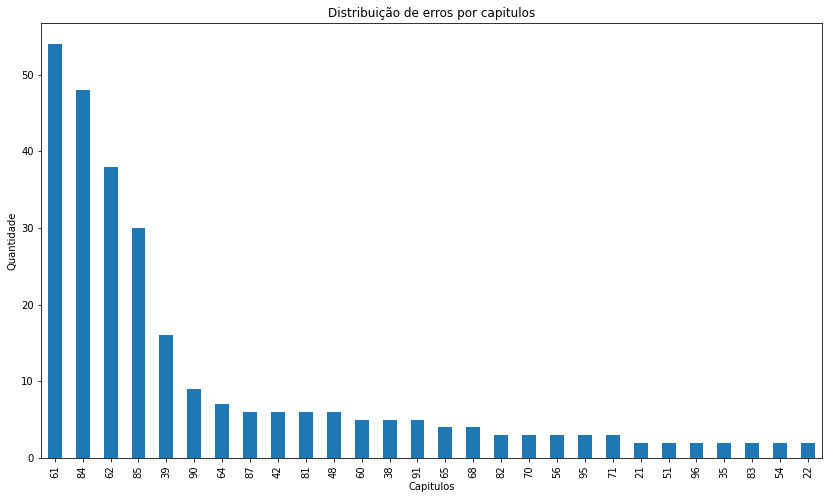

In [60]:
# Cria gráfico de barras
df_temp = pd.DataFrame()
df_temp = df_erros[df_erros['capitulo'] != df_erros.cap_resul]
values = df_temp['cap_resul'].value_counts()
threshold = 1  # define limite inferior para exibição no gráfico (exibir 10 primeiros )
mask = values > threshold  
values = values.loc[mask] # pega os valores que devem ser exibidos

# informações do gráfico
ax = values.plot.bar(figsize=(14,8), title="Distribuição de erros por capitulos")
ax.set_xlabel("Capitulos")
ax.set_ylabel("Quantidade")
print(f"Quantidade de capítulos errados: {len(df_temp['cap_resul'].value_counts())}")

### 9.6 - Erros em posição - detalha quantidade de posições erradass e quantos erros por posição

In [61]:
total_err = {}
for posicao in posicoes_err:
    if total_err.get(posicao):
        total_err[posicao] += 1
    else:
        total_err[posicao] = 1

print(f'Total de posições erradas: {len(total_err.keys())}')
print(f'Total de erros em posiçõss: {len(posicoes_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['posicao'] == str(k).zfill(2)])
    print(f'Posição com erro: {k} => {v} erro(s) em {total_value} = {((v/total_value)*100):.2f}%')

Total de posições erradas: 42
Total de erros em posiçõss: 588 erros

Posição com erro: 17 => 49 erro(s) em 2294 = 2.14%
Posição com erro: 26 => 11 erro(s) em 299 = 3.68%
Posição com erro: 23 => 6 erro(s) em 509 = 1.18%
Posição com erro: 36 => 4 erro(s) em 129 = 3.10%
Posição com erro: 21 => 2 erro(s) em 218 = 0.92%
Posição com erro: 03 => 24 erro(s) em 2393 = 1.00%
Posição com erro: 04 => 32 erro(s) em 2631 = 1.22%
Posição com erro: 19 => 7 erro(s) em 227 = 3.08%
Posição com erro: 11 => 12 erro(s) em 412 = 2.91%
Posição com erro: 82 => 7 erro(s) em 1258 = 0.56%
Posição com erro: 16 => 6 erro(s) em 242 = 2.48%
Posição com erro: 42 => 5 erro(s) em 69 = 7.25%
Posição com erro: 07 => 13 erro(s) em 905 = 1.44%
Posição com erro: 08 => 16 erro(s) em 744 = 2.15%
Posição com erro: 01 => 13 erro(s) em 662 = 1.96%
Posição com erro: 06 => 55 erro(s) em 1261 = 4.36%
Posição com erro: 43 => 4 erro(s) em 326 = 1.23%
Posição com erro: 14 => 81 erro(s) em 1513 = 5.35%
Posição com erro: 10 => 33 erro(s)

Quantidade de posições erradas: 58


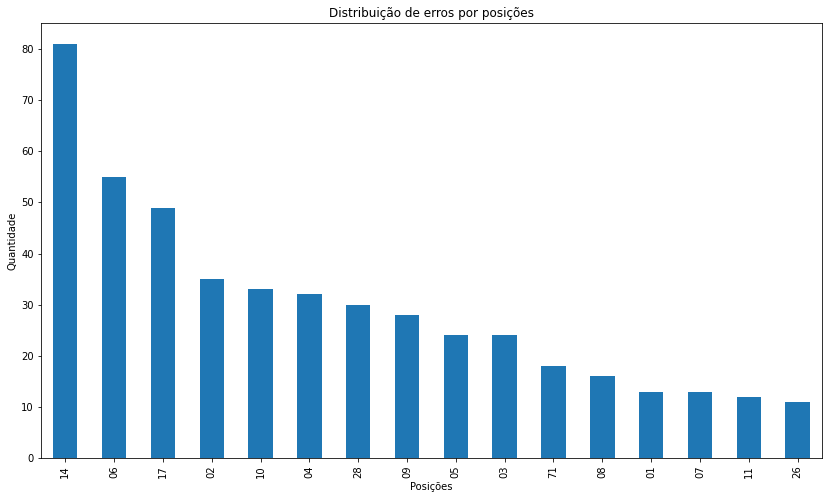

In [62]:
# Cria gráfico de barras
df_temp = pd.DataFrame()
df_temp = df_erros[(df_erros['capitulo'] == df_erros.cap_resul) & 
                   (df_erros['posicao'] != df_erros.pos_resul)]
df_temp.head()
values = df_temp['pos_resul'].value_counts()
threshold = 10  # define limite inferior para exibição no gráfico (exibir 10 primeiros )
mask = values > threshold  
values = values.loc[mask] # pega os valores que devem ser exibidos

# informações do gráfico
ax = values.plot.bar(figsize=(14,8), title="Distribuição de erros por posições")
ax.set_xlabel("Posições")
ax.set_ylabel("Quantidade")
print(f"Quantidade de posições erradas: {len(df_temp['cap_resul'].value_counts())}")

### 9.7 - Erros em subposição, item e subitem - calcula o erro por categoria e a quantidade de erros em cada categoria

In [63]:
total_err = {}
for subposicao in subposicoes_err:
    if total_err.get(subposicao):
        total_err[subposicao] += 1
    else:
        total_err[subposicao] = 1

print(f'Total de subposições erradas: {len(total_err.keys())}')
print(f'Total de erros em subposiçõss: {len(subposicoes_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['subposicao'] == str(k).zfill(2)])
    print(f'Subposição com erro: {k} => {v} erro(s) em {total_value} = {((v/total_value)*100):.2f}%')

Total de subposições erradas: 49
Total de erros em subposiçõss: 3484 erros

Subposição com erro: 80 => 73 erro(s) em 357 = 20.45%
Subposição com erro: 12 => 150 erro(s) em 1280 = 11.72%
Subposição com erro: 90 => 244 erro(s) em 2599 = 9.39%
Subposição com erro: 51 => 31 erro(s) em 437 = 7.09%
Subposição com erro: 11 => 182 erro(s) em 507 = 35.90%
Subposição com erro: 40 => 112 erro(s) em 824 = 13.59%
Subposição com erro: 10 => 115 erro(s) em 2516 = 4.57%
Subposição com erro: 50 => 192 erro(s) em 1001 = 19.18%
Subposição com erro: 39 => 105 erro(s) em 393 = 26.72%
Subposição com erro: 21 => 141 erro(s) em 974 = 14.48%
Subposição com erro: 63 => 45 erro(s) em 209 = 21.53%
Subposição com erro: 32 => 75 erro(s) em 257 = 29.18%
Subposição com erro: 23 => 8 erro(s) em 106 = 7.55%
Subposição com erro: 53 => 46 erro(s) em 51 = 90.20%
Subposição com erro: 99 => 173 erro(s) em 899 = 19.24%
Subposição com erro: 14 => 43 erro(s) em 64 = 67.19%
Subposição com erro: 29 => 209 erro(s) em 628 = 33.28%

In [64]:
total_err = {}
for item in itens_err:
    if total_err.get(item):
        total_err[item] += 1
    else:
        total_err[item] = 1

print(f'Total de itens erradas: {len(total_err.keys())}')
print(f'Total de erros em itens: {len(itens_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['item'] == str(k)])
    print(f'Itens com erro: {k} => {v} erro(s) em {total_value} = {((v/total_value)*100):.2f}%')

Total de itens erradas: 10
Total de erros em itens: 1437 erros

Itens com erro: 9 => 374 erro(s) em 5782 = 6.47%
Itens com erro: 0 => 111 erro(s) em 10731 = 1.03%
Itens com erro: 3 => 76 erro(s) em 1603 = 4.74%
Itens com erro: 1 => 454 erro(s) em 4628 = 9.81%
Itens com erro: 2 => 317 erro(s) em 1646 = 19.26%
Itens com erro: 4 => 57 erro(s) em 842 = 6.77%
Itens com erro: 7 => 22 erro(s) em 291 = 7.56%
Itens com erro: 6 => 4 erro(s) em 110 = 3.64%
Itens com erro: 5 => 21 erro(s) em 336 = 6.25%
Itens com erro: 8 => 1 erro(s) em 135 = 0.74%


In [65]:
total_err = {}
for subitem in subitens_err:
    if total_err.get(subitem):
        total_err[subitem] += 1
    else:
        total_err[subitem] = 1

print(f'Total de subitens erradas: {len(total_err.keys())}')
print(f'Total de erros em subitens: {len(subitens_err)} erros\n')

for k, v in total_err.items():
    total_value = len(df_itens[df_itens['subitem'] == str(k)])
    print(f'Subitens com erro: {k} => {v} erro(s) em {total_value} = {((v/total_value)*100):.2f}%')

Total de subitens erradas: 9
Total de erros em subitens: 1007 erros

Subitens com erro: 7 => 53 erro(s) em 258 = 20.54%
Subitens com erro: 0 => 201 erro(s) em 19432 = 1.03%
Subitens com erro: 1 => 267 erro(s) em 2109 = 12.66%
Subitens com erro: 9 => 188 erro(s) em 2595 = 7.24%
Subitens com erro: 4 => 102 erro(s) em 191 = 53.40%
Subitens com erro: 2 => 113 erro(s) em 910 = 12.42%
Subitens com erro: 3 => 49 erro(s) em 343 = 14.29%
Subitens com erro: 6 => 7 erro(s) em 76 = 9.21%
Subitens com erro: 5 => 27 erro(s) em 140 = 19.29%


In [66]:
for i, row in enumerate(df_erros.iloc[:,0]):
    if df_erros.iloc[i,1] != df_erros.iloc[i,6]:
        print(f'errou capítulo {df_erros.iloc[i,1]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')
    elif df_erros.iloc[i,2] != df_erros.iloc[i,7]:
        print(f'errou posicao {df_erros.iloc[i,2]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')
    elif df_erros.iloc[i,3] != df_erros.iloc[i,8]:
        print(f'errou subposicao {df_erros.iloc[i,3]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')
    elif df_erros.iloc[i,4] != df_erros.iloc[i,9]:
        print(f'errou item {df_erros.iloc[i,4]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')
    elif df_erros.iloc[i,5] != df_erros.iloc[i,10]:
        print(f'errou subitem {df_erros.iloc[i,5]} - ncm: {df_erros.iloc[i, 11]} - ncm_resul= {df_erros.iloc[i, 12]}')

errou item 3 - ncm: 32199030 - ncm_resul= 32199090
errou subposicao 60 - ncm: 85076000 - ncm_resul= 85078000
errou subposicao 90 - ncm: 39269090 - ncm_resul= 39261290
errou subposicao 90 - ncm: 39269090 - ncm_resul= 39261231
errou subposicao 90 - ncm: 39269090 - ncm_resul= 39261290
errou subposicao 90 - ncm: 39269090 - ncm_resul= 39261290
errou subposicao 90 - ncm: 39269090 - ncm_resul= 39261290
errou posicao 04 - ncm: 85044010 - ncm_resul= 85174010
errou posicao 04 - ncm: 85044010 - ncm_resul= 85174010
errou subposicao 70 - ncm: 85177099 - ncm_resul= 85179099
errou item 0 - ncm: 90031100 - ncm_resul= 90031190
errou item 0 - ncm: 90031100 - ncm_resul= 90031190
errou item 0 - ncm: 90031100 - ncm_resul= 90031190
errou item 0 - ncm: 90031100 - ncm_resul= 90031190
errou item 0 - ncm: 90031100 - ncm_resul= 90031190
errou item 0 - ncm: 90031100 - ncm_resul= 90031190
errou capítulo 95 - ncm: 95030031 - ncm_resul= 83012030
errou posicao 04 - ncm: 85044010 - ncm_resul= 85264010
errou subposicao

errou subposicao 00 - ncm: 96140000 - ncm_resul= 96142000
errou subposicao 19 - ncm: 64021900 - ncm_resul= 64021100
errou subposicao 30 - ncm: 61023000 - ncm_resul= 61022000
errou subitem 0 - ncm: 69074000 - ncm_resul= 69074001
errou subposicao 90 - ncm: 32149000 - ncm_resul= 32140000
errou subposicao 59 - ncm: 82055900 - ncm_resul= 82050000
errou capítulo 80 - ncm: 80590000 - ncm_resul= 08590000
errou posicao 95 - ncm: 70959000 - ncm_resul= 70239000
errou subposicao 15 - ncm: 73181500 - ncm_resul= 73181300
errou posicao 67 - ncm: 84671900 - ncm_resul= 84112000
errou capítulo 62 - ncm: 62029900 - ncm_resul= 61143000
errou posicao 06 - ncm: 95069900 - ncm_resul= 95049900
errou posicao 17 - ncm: 61171000 - ncm_resul= 61143000
errou subposicao 40 - ncm: 84824000 - ncm_resul= 84825090
errou subposicao 40 - ncm: 84824000 - ncm_resul= 84825090
errou subposicao 10 - ncm: 84821090 - ncm_resul= 84825090
errou subposicao 10 - ncm: 84821090 - ncm_resul= 84825090
errou posicao 06 - ncm: 61062000 -

errou posicao 06 - ncm: 61061000 - ncm_resul= 61091000
errou posicao 06 - ncm: 61061000 - ncm_resul= 61091000
errou subposicao 10 - ncm: 61061000 - ncm_resul= 61062000
errou posicao 06 - ncm: 62064000 - ncm_resul= 62146300
errou subposicao 44 - ncm: 62044400 - ncm_resul= 62044300
errou subposicao 42 - ncm: 62044200 - ncm_resul= 62044300
errou subposicao 62 - ncm: 62046200 - ncm_resul= 62046300
errou subposicao 12 - ncm: 62021200 - ncm_resul= 62026300
errou subposicao 20 - ncm: 61062000 - ncm_resul= 61063000
errou subitem 9 - ncm: 61151029 - ncm_resul= 61151020
errou subposicao 42 - ncm: 62044200 - ncm_resul= 62044300
errou subposicao 42 - ncm: 62044200 - ncm_resul= 62044300
errou capítulo 61 - ncm: 61062000 - ncm_resul= 62062000
errou capítulo 61 - ncm: 61044300 - ncm_resul= 62044300
errou capítulo 61 - ncm: 61044300 - ncm_resul= 62044300
errou capítulo 61 - ncm: 61044300 - ncm_resul= 62044300
errou posicao 02 - ncm: 61023000 - ncm_resul= 61043000
errou posicao 01 - ncm: 62011300 - ncm

errou subitem 8 - ncm: 03028938 - ncm_resul= 03028934
errou subitem 3 - ncm: 03028943 - ncm_resul= 03028941
errou subitem 4 - ncm: 03028944 - ncm_resul= 03028941
errou subitem 5 - ncm: 03028945 - ncm_resul= 03028942
errou subposicao 13 - ncm: 03031300 - ncm_resul= 03031400
errou subposicao 14 - ncm: 03031400 - ncm_resul= 03031100
errou subposicao 19 - ncm: 03031900 - ncm_resul= 03038900
errou subposicao 23 - ncm: 03032300 - ncm_resul= 03033200
errou posicao 03 - ncm: 03032410 - ncm_resul= 03023210
errou posicao 03 - ncm: 03032490 - ncm_resul= 03023290
errou subposicao 25 - ncm: 03032500 - ncm_resul= 03039300
errou subposicao 26 - ncm: 03032600 - ncm_resul= 03037200
errou subposicao 29 - ncm: 03032900 - ncm_resul= 03033300
errou subposicao 34 - ncm: 03033400 - ncm_resul= 03038900
errou subposicao 39 - ncm: 03033900 - ncm_resul= 03038900
errou subposicao 42 - ncm: 03034200 - ncm_resul= 03034400
errou subposicao 43 - ncm: 03034300 - ncm_resul= 03034900
errou subposicao 45 - ncm: 03034500 

errou item 9 - ncm: 07129090 - ncm_resul= 07129010
errou subposicao 20 - ncm: 07132010 - ncm_resul= 07139010
errou subposicao 20 - ncm: 07132090 - ncm_resul= 07139090
errou item 9 - ncm: 07133290 - ncm_resul= 07133210
errou item 2 - ncm: 07133321 - ncm_resul= 07133311
errou item 9 - ncm: 07133391 - ncm_resul= 07133311
errou subposicao 34 - ncm: 07133410 - ncm_resul= 07133310
errou subposicao 34 - ncm: 07133490 - ncm_resul= 07133390
errou subposicao 35 - ncm: 07133510 - ncm_resul= 07133110
errou subposicao 35 - ncm: 07133590 - ncm_resul= 07133290
errou subposicao 39 - ncm: 07133990 - ncm_resul= 07133290
errou subposicao 40 - ncm: 07134010 - ncm_resul= 07139010
errou subposicao 40 - ncm: 07134090 - ncm_resul= 07139090
errou subposicao 10 - ncm: 07141000 - ncm_resul= 07142000
errou subposicao 90 - ncm: 07149000 - ncm_resul= 07142000
errou subposicao 19 - ncm: 08011900 - ncm_resul= 08011100
errou subposicao 22 - ncm: 08012200 - ncm_resul= 08012100
errou subposicao 31 - ncm: 08013100 - ncm_

errou posicao 04 - ncm: 20049000 - ncm_resul= 20059900
errou subposicao 10 - ncm: 20051000 - ncm_resul= 20059900
errou subposicao 20 - ncm: 20052000 - ncm_resul= 20053000
errou subposicao 59 - ncm: 20055900 - ncm_resul= 20055100
errou subposicao 00 - ncm: 20060000 - ncm_resul= 20069010
errou item 9 - ncm: 20079990 - ncm_resul= 20079919
errou subposicao 30 - ncm: 20083000 - ncm_resul= 20087000
errou subposicao 40 - ncm: 20084090 - ncm_resul= 20083090
errou subposicao 50 - ncm: 20085000 - ncm_resul= 20089000
errou subposicao 80 - ncm: 20088000 - ncm_resul= 20089000
errou subposicao 91 - ncm: 20089100 - ncm_resul= 20089990
errou subposicao 97 - ncm: 20089710 - ncm_resul= 20089910
errou subposicao 97 - ncm: 20089790 - ncm_resul= 20089990
errou item 0 - ncm: 20089900 - ncm_resul= 20089990
errou item 0 - ncm: 20091100 - ncm_resul= 20091190
errou item 0 - ncm: 20091900 - ncm_resul= 20091990
errou subposicao 50 - ncm: 20095000 - ncm_resul= 20099090
errou subposicao 61 - ncm: 20096100 - ncm_res

errou item 6 - ncm: 28332960 - ncm_resul= 28332920
errou item 7 - ncm: 28332970 - ncm_resul= 28332920
errou item 9 - ncm: 28332990 - ncm_resul= 28332900
errou subposicao 30 - ncm: 28333000 - ncm_resul= 28334000
errou item 2 - ncm: 28334020 - ncm_resul= 28334010
errou item 9 - ncm: 28334090 - ncm_resul= 28334020
errou subposicao 10 - ncm: 28341090 - ncm_resul= 28342990
errou subitem 0 - ncm: 28342910 - ncm_resul= 28342911
errou item 3 - ncm: 28342930 - ncm_resul= 28342990
errou subitem 9 - ncm: 28351019 - ncm_resul= 28351011
errou subposicao 22 - ncm: 28352200 - ncm_resul= 28352900
errou subposicao 24 - ncm: 28352400 - ncm_resul= 28352900
errou subposicao 25 - ncm: 28352500 - ncm_resul= 28352900
errou subposicao 26 - ncm: 28352600 - ncm_resul= 28352900
errou item 1 - ncm: 28352910 - ncm_resul= 28352990
errou item 5 - ncm: 28352950 - ncm_resul= 28352930
errou item 9 - ncm: 28352990 - ncm_resul= 28352900
errou item 3 - ncm: 28353930 - ncm_resul= 28353920
errou item 9 - ncm: 28362090 - ncm

errou subitem 4 - ncm: 29336914 - ncm_resul= 29336915
errou item 1 - ncm: 29336916 - ncm_resul= 29336925
errou item 1 - ncm: 29336919 - ncm_resul= 29336929
errou subitem 1 - ncm: 29336921 - ncm_resul= 29336929
errou subitem 1 - ncm: 29339111 - ncm_resul= 29339112
errou subitem 3 - ncm: 29339113 - ncm_resul= 29339112
errou subitem 4 - ncm: 29339114 - ncm_resul= 29339112
errou subitem 5 - ncm: 29339115 - ncm_resul= 29339112
errou subitem 9 - ncm: 29339119 - ncm_resul= 29339112
errou subitem 1 - ncm: 29339121 - ncm_resul= 29339129
errou subitem 3 - ncm: 29339123 - ncm_resul= 29339122
errou subitem 9 - ncm: 29339129 - ncm_resul= 29339122
errou subitem 1 - ncm: 29339131 - ncm_resul= 29339132
errou subitem 3 - ncm: 29339133 - ncm_resul= 29339132
errou subitem 4 - ncm: 29339134 - ncm_resul= 29339132
errou subitem 9 - ncm: 29339139 - ncm_resul= 29339132
errou subitem 1 - ncm: 29339141 - ncm_resul= 29339149
errou subitem 3 - ncm: 29339143 - ncm_resul= 29339149
errou item 5 - ncm: 29339151 - ncm

errou item 9 - ncm: 34012090 - ncm_resul= 34012010
errou subposicao 30 - ncm: 34013000 - ncm_resul= 34012000
errou subposicao 13 - ncm: 34021300 - ncm_resul= 34029000
errou subposicao 19 - ncm: 34021900 - ncm_resul= 34029000
errou subposicao 20 - ncm: 34022000 - ncm_resul= 34029000
errou subitem 9 - ncm: 34029019 - ncm_resul= 34029010
errou subposicao 11 - ncm: 34031110 - ncm_resul= 34031910
errou item 9 - ncm: 34031190 - ncm_resul= 34031120
errou subposicao 19 - ncm: 34031900 - ncm_resul= 34031110
errou subposicao 91 - ncm: 34039110 - ncm_resul= 34031910
errou item 9 - ncm: 34039190 - ncm_resul= 34039120
errou subposicao 99 - ncm: 34039900 - ncm_resul= 34039110
errou item 1 - ncm: 34042010 - ncm_resul= 34042020
errou subposicao 10 - ncm: 34051000 - ncm_resul= 34054000
errou subposicao 40 - ncm: 34054000 - ncm_resul= 34051000
errou subposicao 90 - ncm: 34059000 - ncm_resul= 34054000
errou item 1 - ncm: 34070010 - ncm_resul= 34070020
errou subposicao 10 - ncm: 35011000 - ncm_resul= 3501

errou subposicao 19 - ncm: 44071900 - ncm_resul= 44071100
errou subposicao 25 - ncm: 44072500 - ncm_resul= 44071100
errou subposicao 26 - ncm: 44072600 - ncm_resul= 44073100
errou subposicao 27 - ncm: 44072700 - ncm_resul= 44072900
errou subposicao 28 - ncm: 44072800 - ncm_resul= 44072900
errou item 3 - ncm: 44072930 - ncm_resul= 44072990
errou item 9 - ncm: 44072990 - ncm_resul= 44072920
errou subposicao 94 - ncm: 44079400 - ncm_resul= 44079300
errou subposicao 96 - ncm: 44079600 - ncm_resul= 44079500
errou subposicao 97 - ncm: 44079700 - ncm_resul= 44079900
errou item 6 - ncm: 44079960 - ncm_resul= 44079900
errou subposicao 99 - ncm: 44079990 - ncm_resul= 44072990
errou subitem 0 - ncm: 44081010 - ncm_resul= 44081019
errou subposicao 10 - ncm: 44081099 - ncm_resul= 44083919
errou subposicao 31 - ncm: 44083110 - ncm_resul= 44083910
errou subposicao 31 - ncm: 44083190 - ncm_resul= 44083910
errou subitem 0 - ncm: 44083910 - ncm_resul= 44083911
errou item 9 - ncm: 44083991 - ncm_resul= 4

errou subposicao 42 - ncm: 55164200 - ncm_resul= 55163000
errou subposicao 43 - ncm: 55164300 - ncm_resul= 55163000
errou subposicao 44 - ncm: 55164400 - ncm_resul= 55163000
errou subposicao 91 - ncm: 55169100 - ncm_resul= 55162100
errou subposicao 92 - ncm: 55169200 - ncm_resul= 55162200
errou subposicao 93 - ncm: 55169300 - ncm_resul= 55164300
errou subposicao 94 - ncm: 55169400 - ncm_resul= 55169200
errou subposicao 21 - ncm: 56012110 - ncm_resul= 56012211
errou subposicao 21 - ncm: 56012190 - ncm_resul= 56012210
errou item 1 - ncm: 56012219 - ncm_resul= 56012291
errou subitem 1 - ncm: 56012291 - ncm_resul= 56012290
errou subitem 9 - ncm: 56012299 - ncm_resul= 56012291
errou subposicao 29 - ncm: 56012900 - ncm_resul= 56012290
errou subposicao 21 - ncm: 56022100 - ncm_resul= 56021000
errou subposicao 11 - ncm: 56031110 - ncm_resul= 56031210
errou subposicao 11 - ncm: 56031120 - ncm_resul= 56031220
errou subposicao 11 - ncm: 56031130 - ncm_resul= 56031230
errou item 4 - ncm: 56031140 

errou posicao 09 - ncm: 72099000 - ncm_resul= 72109000
errou subposicao 12 - ncm: 72101200 - ncm_resul= 72101110
errou subposicao 20 - ncm: 72102000 - ncm_resul= 72109000
errou subposicao 30 - ncm: 72103010 - ncm_resul= 72102010
errou subposicao 49 - ncm: 72104910 - ncm_resul= 72101210
errou subposicao 49 - ncm: 72104990 - ncm_resul= 72103090
errou item 0 - ncm: 72105000 - ncm_resul= 72105020
errou subposicao 61 - ncm: 72106100 - ncm_resul= 72105000
errou subposicao 69 - ncm: 72106990 - ncm_resul= 72109090
errou subposicao 70 - ncm: 72107010 - ncm_resul= 72104010
errou subposicao 70 - ncm: 72107020 - ncm_resul= 72104020
errou subposicao 13 - ncm: 72111300 - ncm_resul= 72113100
errou posicao 11 - ncm: 72111400 - ncm_resul= 72081420
errou posicao 11 - ncm: 72111900 - ncm_resul= 72082990
errou subposicao 23 - ncm: 72112300 - ncm_resul= 72111100
errou item 2 - ncm: 72112920 - ncm_resul= 72112910
errou posicao 11 - ncm: 72119010 - ncm_resul= 72102910
errou posicao 11 - ncm: 72119090 - ncm_r

errou subposicao 19 - ncm: 76071990 - ncm_resul= 76071190
errou subposicao 20 - ncm: 76072000 - ncm_resul= 76071190
errou posicao 08 - ncm: 76081000 - ncm_resul= 76062990
errou posicao 08 - ncm: 76082090 - ncm_resul= 76062990
errou posicao 09 - ncm: 76090000 - ncm_resul= 76071900
errou posicao 11 - ncm: 76110000 - ncm_resul= 76090090
errou subposicao 10 - ncm: 76121000 - ncm_resul= 76129099
errou posicao 12 - ncm: 76129012 - ncm_resul= 76101012
errou subposicao 90 - ncm: 76129090 - ncm_resul= 76122990
errou posicao 13 - ncm: 76130000 - ncm_resul= 76110000
errou item 9 - ncm: 76141090 - ncm_resul= 76141010
errou subposicao 90 - ncm: 76149010 - ncm_resul= 76141090
errou subposicao 90 - ncm: 76149090 - ncm_resul= 76141010
errou subposicao 10 - ncm: 76151000 - ncm_resul= 76152000
errou subposicao 20 - ncm: 76152000 - ncm_resul= 76159000
errou posicao 16 - ncm: 76169100 - ncm_resul= 76081900
errou item 0 - ncm: 76169900 - ncm_resul= 76169990
errou subposicao 10 - ncm: 78011011 - ncm_resul= 

errou subposicao 20 - ncm: 84392000 - ncm_resul= 84393000
errou item 2 - ncm: 84393020 - ncm_resul= 84393030
errou item 9 - ncm: 84393090 - ncm_resul= 84393030
errou subposicao 91 - ncm: 84399100 - ncm_resul= 84393090
errou item 1 - ncm: 84401019 - ncm_resul= 84401099
errou subposicao 10 - ncm: 84401020 - ncm_resul= 84408020
errou subitem 0 - ncm: 84401090 - ncm_resul= 84401099
errou item 0 - ncm: 84409000 - ncm_resul= 84409099
errou subposicao 10 - ncm: 84411010 - ncm_resul= 84412010
errou subposicao 10 - ncm: 84411090 - ncm_resul= 84412090
errou capítulo 84 - ncm: 84414000 - ncm_resul= 48413000
errou subposicao 80 - ncm: 84418000 - ncm_resul= 84412090
errou item 0 - ncm: 84419000 - ncm_resul= 84419090
errou subitem 0 - ncm: 84424010 - ncm_resul= 84424011
errou subposicao 40 - ncm: 84424090 - ncm_resul= 84423090
errou subposicao 50 - ncm: 84425000 - ncm_resul= 84423090
errou subposicao 11 - ncm: 84431190 - ncm_resul= 84431390
errou subposicao 12 - ncm: 84431200 - ncm_resul= 84431391
e

errou item 2 - ncm: 84642029 - ncm_resul= 84642099
errou item 1 - ncm: 84649019 - ncm_resul= 84649099
errou subposicao 20 - ncm: 84652000 - ncm_resul= 84659100
errou subitem 9 - ncm: 84659219 - ncm_resul= 84659211
errou subposicao 93 - ncm: 84659390 - ncm_resul= 84659190
errou subposicao 94 - ncm: 84659400 - ncm_resul= 84659190
errou subposicao 95 - ncm: 84659511 - ncm_resul= 84651011
errou subposicao 95 - ncm: 84659512 - ncm_resul= 84659112
errou subposicao 95 - ncm: 84659591 - ncm_resul= 84651091
errou subposicao 95 - ncm: 84659592 - ncm_resul= 84659192
errou subposicao 96 - ncm: 84659600 - ncm_resul= 84659120
errou subposicao 99 - ncm: 84659900 - ncm_resul= 84659190
errou subposicao 10 - ncm: 84661000 - ncm_resul= 84669310
errou subposicao 20 - ncm: 84662010 - ncm_resul= 84669311
errou subposicao 20 - ncm: 84662090 - ncm_resul= 84669391
errou subposicao 30 - ncm: 84663000 - ncm_resul= 84669390
errou subposicao 91 - ncm: 84669100 - ncm_resul= 84669300
errou subposicao 92 - ncm: 84669

errou subitem 9 - ncm: 85402019 - ncm_resul= 85402010
errou item 2 - ncm: 85402020 - ncm_resul= 85402010
errou item 9 - ncm: 85402090 - ncm_resul= 85402010
errou subposicao 40 - ncm: 85404000 - ncm_resul= 85402010
errou subposicao 60 - ncm: 85406010 - ncm_resul= 85402010
errou subposicao 60 - ncm: 85406090 - ncm_resul= 85409190
errou subposicao 71 - ncm: 85407100 - ncm_resul= 85407900
errou subposicao 79 - ncm: 85407900 - ncm_resul= 85409100
errou subposicao 81 - ncm: 85408100 - ncm_resul= 85408900
errou item 9 - ncm: 85408990 - ncm_resul= 85408900
errou item 2 - ncm: 85409120 - ncm_resul= 85409110
errou subposicao 99 - ncm: 85409900 - ncm_resul= 85409190
errou item 1 - ncm: 85411011 - ncm_resul= 85411091
errou subposicao 10 - ncm: 85411012 - ncm_resul= 85414012
errou subposicao 10 - ncm: 85411019 - ncm_resul= 85414092
errou subitem 9 - ncm: 85411029 - ncm_resul= 85411022
errou subposicao 10 - ncm: 85411092 - ncm_resul= 85414012
errou subposicao 10 - ncm: 85411099 - ncm_resul= 85414092

errou subposicao 29 - ncm: 85182990 - ncm_resul= 85182100
errou capítulo 84 - ncm: 84733099 - ncm_resul= 85734209
errou subposicao 19 - ncm: 48101999 - ncm_resul= 48102009
errou capítulo 62 - ncm: 62044900 - ncm_resul= 61044900
errou item 0 - ncm: 35069900 - ncm_resul= 35069990
errou subposicao 40 - ncm: 85044029 - ncm_resul= 85043129
errou subitem 0 - ncm: 84714110 - ncm_resul= 84714111
errou item 9 - ncm: 85437099 - ncm_resul= 85437009
errou subitem 9 - ncm: 30049099 - ncm_resul= 30049090
errou subitem 0 - ncm: 85235190 - ncm_resul= 85235199
errou subitem 4 - ncm: 85176254 - ncm_resul= 85176253
errou subposicao 92 - ncm: 71069290 - ncm_resul= 71061990
errou item 9 - ncm: 85171290 - ncm_resul= 85171272
errou item 1 - ncm: 85043119 - ncm_resul= 85043129
errou posicao 22 - ncm: 84223029 - ncm_resul= 84023029
errou subitem 1 - ncm: 85176241 - ncm_resul= 85176249
errou posicao 25 - ncm: 85256090 - ncm_resul= 85176250
errou posicao 05 - ncm: 64059000 - ncm_resul= 64021900
errou posicao 17 

errou subitem 0 - ncm: 84714110 - ncm_resul= 84714111
errou item 0 - ncm: 85182100 - ncm_resul= 85182190
errou subposicao 10 - ncm: 87141000 - ncm_resul= 87149000
errou posicao 26 - ncm: 39262000 - ncm_resul= 39052000
errou subposicao 95 - ncm: 87089529 - ncm_resul= 87081029
errou posicao 48 - ncm: 85481010 - ncm_resul= 85078010
errou subposicao 29 - ncm: 85182990 - ncm_resul= 85182190
errou item 9 - ncm: 85256090 - ncm_resul= 85256050
errou capítulo 90 - ncm: 90330000 - ncm_resul= 42029000
errou item 1 - ncm: 85171219 - ncm_resul= 85171239
errou subitem 0 - ncm: 85235190 - ncm_resul= 85235199
errou capítulo 65 - ncm: 65050019 - ncm_resul= 61149000
errou posicao 04 - ncm: 95049090 - ncm_resul= 95039090
errou capítulo 85 - ncm: 85171231 - ncm_resul= 84171231
errou capítulo 23 - ncm: 23099090 - ncm_resul= 21099090
errou item 1 - ncm: 84714110 - ncm_resul= 84714130
errou subposicao 10 - ncm: 87141000 - ncm_resul= 87149000
errou item 0 - ncm: 91021900 - ncm_resul= 91021990
errou capítulo 4